<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Image_Classification_using_BigTransfer_(BiT)_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

In [63]:
train_ds, validation_ds = tfds.load("tf_flowers", split = ["train[:85]", "train[85:]"], as_supervised = True)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [66]:
for x in train_ds.take(1):
    print(x)

(<tf.Tensor: shape=(333, 500, 3), dtype=uint8, numpy=
array([[[ 93, 122,  30],
        [ 90, 118,  31],
        [ 88, 118,  28],
        ...,
        [247,  77,  78],
        [253,  87,  87],
        [255,  76,  75]],

       [[ 98, 125,  30],
        [ 95, 124,  32],
        [ 96, 125,  32],
        ...,
        [247,  81,  83],
        [250,  86,  84],
        [252,  71,  64]],

       [[ 98, 126,  26],
        [101, 128,  31],
        [106, 132,  33],
        ...,
        [254,  81,  85],
        [254,  79,  76],
        [252,  55,  47]],

       ...,

       [[ 35,  51,   6],
        [ 21,  49,   0],
        [ 30,  57,   6],
        ...,
        [224, 239,  78],
        [192, 208,  50],
        [ 88,  54,  53]],

       [[ 65,  73,  32],
        [ 20,  46,   0],
        [ 22,  48,   0],
        ...,
        [230, 236,  74],
        [230, 246,  62],
        [ 88,  57,  36]],

       [[ 95,  97,  60],
        [ 15,  41,   0],
        [ 23,  51,   3],
        ...,
        [210, 224,  

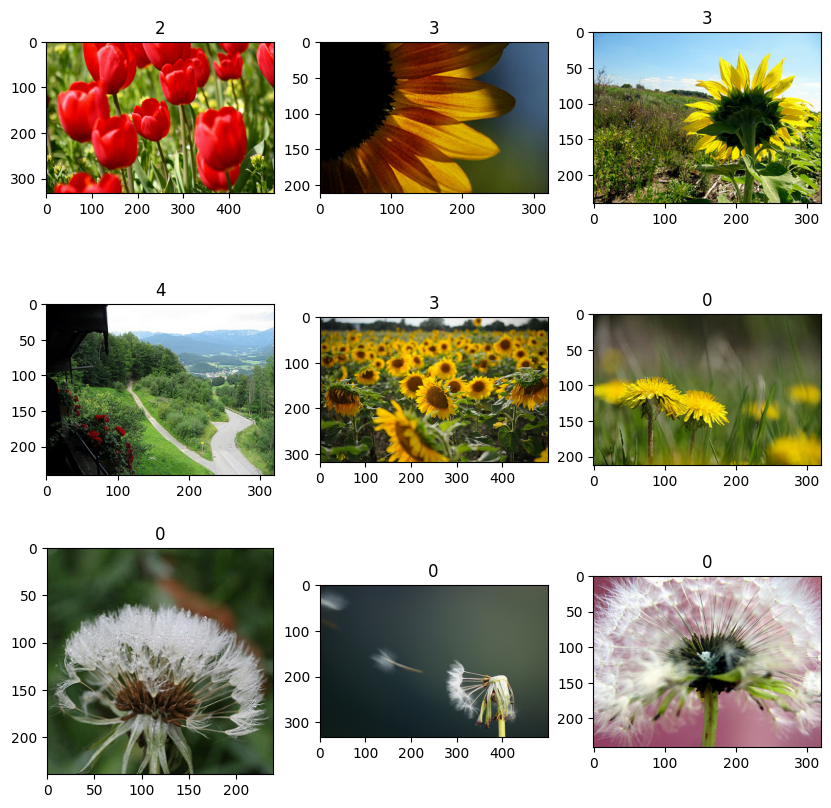

In [85]:
plt.figure(figsize=(10,10))
for i, (img, lab) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.title(int(lab))
  #plt.show()


The hyperparamteres like SCHEDULE_LENGTH and SCHEDULE_BOUNDARIES are determined based on empirical results. The method has been explained in the original paper and in their Google AI Blog Post.
The SCHEDULE_LENGTH is aslo determined whether to use MixUp Augmentation or not. You can also find an easy MixUp Implementation in Keras Coding Examples.

In [86]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]

**Define preprocessing helper functions**

In [87]:

SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE


@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

In [88]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

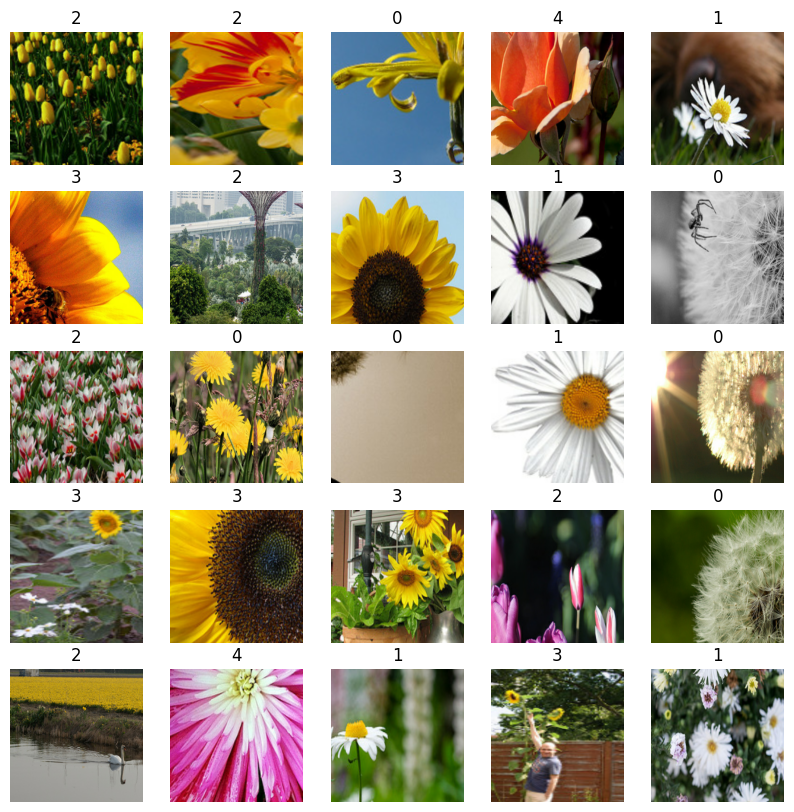

In [89]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

**Load pretrained TF-Hub model into a KerasLayer**

In [90]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

Create BigTransfer (BiT) model
To create the new model, we:
Cut off the BiT model’s original head. This leaves us with the “pre-logits” output. We do not have to do this if we use the ‘feature extractor’ models (i.e. all those in subdirectories titled feature_vectors), since for those models the head has already been cut off.
Add a new head with the number of outputs equal to the number of classes of our new task. Note that it is important that we initialise the head to all zeroes.

In [91]:

class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [ ]:
###Define optimizer and loss

In [93]:

learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [94]:

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [96]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

In [ ]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/400
10/10 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.7672 